In [1]:
import sys
import numpy as np
import gym
import ray
from ray.rllib.agents import ppo, a3c, cql, ddpg, dqn

gym.logger.set_level(40)

sys.path.append("..")

from source.envs.env import WhitedBasicModel
from source.solvers.ray_solver import RaySolver

%load_ext autoreload

A3C_Trainer = a3c.A3CTrainer
PPO_Trainer = ppo.PPOTrainer
DQNTrainer = dqn.DQNTrainer

In [3]:
from source.utils.useful_class import ParameterGrid

grid = {
        'delta': [0.1, 0.2, 0.3],
        'gamma': [1, 10]
    }
pg = ParameterGrid(grid)
for g in pg:
    print(g)
    

{'delta': 0.1, 'gamma': 1}
{'delta': 0.1, 'gamma': 10}
{'delta': 0.2, 'gamma': 1}
{'delta': 0.2, 'gamma': 10}
{'delta': 0.3, 'gamma': 1}
{'delta': 0.3, 'gamma': 10}


In [2]:
ray.shutdown()
ray.init()
env = WhitedBasicModel(env_config={"structural_params": {"gamma": [0.9,0.96],
                                                         "delta": [0.1, 0.3],
                                                         "theta": [0.5, 0.8],
                                                         "rho": [0.3, 0.8],
                                                         "sigma": [0., 0.15],
                                                        }, 
                                   "env_params": {"psi_func": lambda i, k: 0.01*i**2/(2*k)
                                                 },
                                   "is_mutable": True,
                                  })
solver = RaySolver(env=env,
                   trainer=A3C_Trainer,
                   solver_params={"verbose": True, "episodes": 30,
                                  "trainer_config": {
                                      "num_workers": 8,
                                      "gamma": env.current_structural_params.get("gamma", 0.99),
                                  }
                                  })
solver.train()
ray.shutdown()

2022-01-12 23:54:14,470	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8266
2022-01-12 23:54:15,518	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


{'verbose': True, 'episodes': 30, 'trainer_config': {'num_workers': 8, 'gamma': 0.99}}


(RolloutWorker pid=6329) 2022-01-12 23:54:17,315	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-01-12 23:54:17,368	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-01-12 23:54:17,375	WARNING util.py:57 -- Install gputil for GPU system monitoring.


agent_timesteps_total: 0
custom_metrics: {}
date: 2022-01-12_23-54-17
done: false
episode_len_mean: .nan
episode_media: {}
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: 82484fc6cad346d986a203a079c55af9
hostname: mw-14.local
info:
  learner:
    default_policy:
      batch_count: 10
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0001
        entropy_coeff: 0.01
        grad_gnorm: 241.7726593017578
        policy_entropy: 29.957176208496094
        policy_loss: 156.156982421875
        vf_loss: 169.4228973388672
  num_steps_sampled: 10
  num_steps_trained: 10
iterations_since_restore: 1
node_ip: 127.0.0.1
num_healthy_workers: 8
off_policy_estimator: {}
perf:
  cpu_util_percent: 38.9
  ram_util_percent: 89.3
pid: 6297
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf: {}
time_since_restore: 0.06924104690551758
time_this_iter_s: 0.06924104690551758
time

In [15]:
solver.trainer.save()

'/Users/mingweima/ray_results/A3C_my-env_2022-01-04_15-11-160hhhuamk/checkpoint_000030/checkpoint-30'

In [3]:
# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = solver.act(obs)
    obs, reward, done, info = env.step(action, resample_param=False)
    episode_reward += reward
    print(obs, action, reward, done, info)

[1.55043662 0.94101024 0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 16 0.1543490304709142 False {}
[2.40385365 1.07871056 0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 16 -0.03688304788944441 False {}
[3.72702289 1.20395291 0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 16 -0.05483967130247369 False {}
[5.77851295 1.12355947 0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 16 -0.16235066277430743 False {}
[5.91789579 0.8079899  0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 6 1.9500532256119953 False {}
[9.17532253 0.98601341 0.93119333 0.29166863 0.6912884  0.67761639
 0.11232307] 16 -2.242648829290617 False {}
[14.22575665  1.07891905  0.93119333  0.29166863  0.6912884   0.67761639
  0.11232307] 16 -3.1952659595525548 False {}
[14.56889439  1.06649446  0.93119333  0.29166863  0.6912884   0.67761639
  0.11232307] 6 2.2628946204890905 False {}
[22.58814812  1.07647991  0.93119333  0.29166863  0.6912884   0.67761639
  0.11232307] 16 -5.

In [32]:
"""Test trained agent for a single episode. Return the episode reward"""
cp = []
for eps in range(2):
      # instantiate env class
      episode_reward = 0
      done = False
      obs = env.reset()
      # run until episode ends
      caps = []
      while not done:
          action = solver.trainer.compute_single_action(obs, clip_action=True)
          obs, reward, done, info = env.step(action, resample_param=False)
          episode_reward += reward
          #print(action, obs, reward, done)
          caps += [obs[0]]
      cp += [ [caps] ]
cp = np.squeeze(np.array(cp)).mean(axis=0)

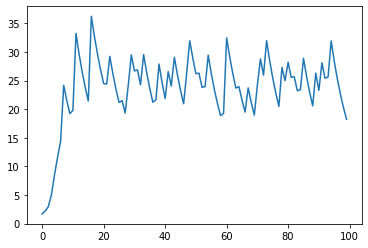

In [33]:
import matplotlib.pyplot as plt
plt.plot(cp)
plt.show()